### Load demo dependencies

In [1]:
import os
import json
import shutil
from ghost import *
from ghost.bids import *

### Setup demo project environment
We set up the demo project inside the GHOST directory

In [2]:
# setup demo path to demonstration
demo_dir=f'{GHOSTDIR}/demo'
os.makedirs(demo_dir, exist_ok=True)
os.environ['PROJECT_DIR'] = demo_dir # Set environment variable for use in other scripts

# raise scaffold to support BIDS structure
folders=['code', 'sourcedata', 'rawdata', 'derivatives']
for folder in folders:
    os.makedirs(os.path.join(demo_dir,folder), exist_ok=True)

# put needful code in place (turns messy DICOM directory into sparkling BIDS structure)
shutil.copytree(f'{GHOSTDIR}/dcm2bids', os.path.join(demo_dir,'code/dcm2bids'), dirs_exist_ok=True)

'/Users/petter/Code/GHOST/demo/code/dcm2bids'


### Get some demo-data (from Lund!)

Now you have 2 options...

1. Download [demo data](https://www.dropbox.com/s/e4lasb3xi1ryed0/Lund_DailyQA_Example.zip?dl=1) and unzip inside `sourcedata/`, or
2. Use the following code to do it for you

In [3]:
import urllib.request
import zipfile

# specify the URL of the zip file, the destination folder path, and the zip file name
url = 'https://www.dropbox.com/s/p0uzg47wppknpyg/LUND_DailyQA_demo.zip?dl=1'
dest_folder = f'{demo_dir}/sourcedata'
zip_file_name = 'Lund_DailyQA_Example.zip'

# download the zip file and save it to the destination folder
urllib.request.urlretrieve(url, os.path.join(dest_folder, zip_file_name))

# extract the contents of the zip file to the destination folder
with zipfile.ZipFile(os.path.join(dest_folder, zip_file_name), 'r') as zip_ref:
    zip_ref.extractall(dest_folder)

# delete the original zip file
os.remove(os.path.join(dest_folder, zip_file_name))

if os.path.exists(os.path.join(dest_folder, '__MACOSX')):
    shutil.rmtree(os.path.join(dest_folder, '__MACOSX'))

Now we have defined one non-BIDS dataset (`sourcedata`), and two BIDS datasets: `Rawdata` and `Derivatives`. As for any BIDS dataset, a `dataset_description.json` file must be found at the top level. Therefore, we must create these two before we can BIDS-ify our source data.

In [4]:
# Create the dataset_description.json file for the rawdata folder
with open(os.path.join(demo_dir,'rawdata/dataset_description.json'), 'w') as f:
    # Here is what the file should resemble
    json.dump(
        {
            "Name": "demo",
            "BIDSVersion": "1.8",
            "DatasetType": "raw",
            "License": "PD",
            "Authors": [
                "Petter Clemensson",
                "Emil Ljungberg",
                ],
            "Funding": "Bill & Melinda Gates Foundation",
        }
        , f, indent=4)

Only `Name` and `BIDSVersion` are required fields, while the others are recommended/optional. More info available on the [BIDS website](https://bids-specification.readthedocs.io/en/stable/03-modality-agnostic-files.html#dataset_descriptionjson).

In [5]:
# Create the dataset_description.json file for the derivatives folder
with open(os.path.join(demo_dir,'derivatives/dataset_description.json'), 'w') as f:
    # Here is what the file should resemble
    json.dump(
        {
            "Name": "demo",
            "BIDSVersion": "1.8",
            "DatasetType": "derivative",
            "License": "PD",
            "Authors": [
                "Petter Clemensson",
                "Emil Ljungberg",
                ],
            "Funding": "Bill & Melinda Gates Foundation",
            "GeneratedBy": [
                {
                    "Name": "masks",
                    "Description": "Segmentations for all the images in the dataset"
                },
                {
                    "Name": "qa",
                    "Description": "Quality assurance for all the image in the dataset"
                },
                {
                    "Name": "stats",
                    "Description": "Statistics for all the image in the dataset",
                },
            ],
            
        }
        , f, indent=4)

Before we intiate the BIDS-ification, we may want to define some additional DICOM tags (metadata) that we want to add to the JSON sidecar, as not everything is included when using `dcm2bids`. For this purpose, we use a function available through the swoop_QMRI package, `swoop_update_sidecar`. It requires a `dicom_update_tags.csv` file, which we can add to our `code/` directory by running the following cell.

In [7]:
with open(os.path.join(demo_dir,'code/dicom_update_tags.csv'), 'w') as f:
    # Here is what the file should resemble
    lines = ['DicomTag, dtype, regex, name\n',
             '0x03511000, float, None, tmp_min\n',
             '0x03511001, float, None, tmp_max\n',
             '0x03511002, float, None, uint_x_max\n',
             '0x00104000, int, \d{2}, Temperature\n',
             '0x52009229/0x00189006/0x00189098, float, None, CenterFrequency']
    f.writelines(lines)

### Sourcedata &rarr; Rawdata (BIDS!)
Usually this is done by excecuting `bash run_dcm2bids.sh`. When working on your own project, set `PROJECT_DIR` to your project directory before the execution.

The next cell mirrors `run_dcm2bids.sh` so there is no need to leave this demo to edit the file. The only difference is that `PROJECT_DIR` is automatically assigned the demo project directory.

In [8]:
%%bash

PARTICIPANT_ID="LUND"

DICOM_DIR="$PROJECT_DIR/sourcedata/*"
CONFIG_FILE="$PROJECT_DIR/code/dcm2bids/config.json"
OUTPUT_DIR="$PROJECT_DIR/rawdata"

i=1
for DIR in $DICOM_DIR
do
    # extract the session ID from the dicom directory name
    if [[ $DIR =~ [0-9]{8} ]]; then
        SESSION_ID=$(echo $DIR | grep -oE "[0-9]{8}")
    # session ID is set to the session number if the directory name does not contain a date
    else
        SESSION_ID=$i
        i=$((i+1))
    fi

  # run the function on the directory and session ID
  dcm2bids -d $DIR -p $PARTICIPANT_ID -s $SESSION_ID -c $CONFIG_FILE -o $OUTPUT_DIR
  
  # Transfer metadata from DICOM tags in dicom_update_tags.csv to sidecar files
  swoop_update_sidecar $DIR $OUTPUT_DIR/sub-$PARTICIPANT_ID/ses-$SESSION_ID -m $PROJECT_DIR/code/dicom_update_tags.csv
done

INFO:dcm2bids.dcm2bids:--- dcm2bids start ---
INFO:dcm2bids.dcm2bids:OS:version: macOS-13.3.1-arm64-arm-64bit
INFO:dcm2bids.dcm2bids:python:version: 3.10.9 (main, Jan 11 2023, 09:18:18) [Clang 14.0.6 ]
INFO:dcm2bids.dcm2bids:dcm2bids:version: 2.1.7
INFO:dcm2bids.dcm2bids:dcm2niix:version: v1.0.20230411
INFO:dcm2bids.dcm2bids:participant: sub-LUND
INFO:dcm2bids.dcm2bids:session: ses-20230329
INFO:dcm2bids.dcm2bids:config: /Users/petter/Code/GHOST/demo/code/dcm2bids/config.json
INFO:dcm2bids.dcm2bids:BIDS directory: /Users/petter/Code/GHOST/demo/rawdata
INFO:dcm2bids.utils:Running ['dcm2niix', '-b', 'y', '-ba', 'y', '-z', 'y', '-f', '%3s_%f_%p_%t', '-x', 'i', '-o', PosixPath('/Users/petter/Code/GHOST/demo/rawdata/tmp_dcm2bids/sub-LUND_ses-20230329'), PosixPath('/Users/petter/Code/GHOST/demo/sourcedata/LUND_20230329_DailyQA_demo')]
INFO:dcm2bids.dcm2niix:Check log file for dcm2niix output
INFO:dcm2bids.sidecar:Sidecars pairing:
INFO:dcm2bids.sidecar:No Pairing  <-  003_LUND_20230329_Daily

### Final comment on the BIDS-ification
Now the `rawdata/` folder contains a BIDS compatible directory (`sub-LUND/`) and a temporary folder (`tmp_dcm2bids`). In the temporary folder we find files that were converted to NIFTI, but couldn't be BIDSified. This can happen for a few reasons. 
1. No match was find with the description criteria in the `config.json` file. (Here, we're not interested in the localizer image so we couldn't be bothered to include an identifier for it). If you want to practice, go and edit the `config.json` file and re-run the previous cell until the localizer image is successfully BIDSified.
2. Multiple matches were found for a single description criterion. If this is the case, you can inspect the sidecar file and look for the "SeriesDescription" field for example. It is often a good unique identifier.

For a more comprehensive tutorial, check [this](https://unfmontreal.github.io/Dcm2Bids/docs/tutorial/first-steps/) out.

### Swift analysis
Here follows some basic analysis examples that aim to get you started. Manipulate as you wish to suit your own needs.

In [9]:
# Get project layout and update 
layout = bids.BIDSLayout(root=demo_dir+'/rawdata', derivatives=demo_dir+'/derivatives')

# Select all fast axial T2 images
bids_files = layout.get(scope='raw', extension='.nii.gz', suffix='T2w', reconstruction='axi', acquisition='fast')

# Get the stats for the T2 images and save to Excel
stats_T2 = bids2stats(bids_files, 'T2', layout, toExcel=True, verbose=True)
print(f"Stats for some T2 data: \n {stats_T2}")

A T2-mask does not exist for sub-LUND_ses-20230329_acq-fast_rec-axi_T2w.nii.gz. Molding one now.
Saving T2 mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230329/anat/sub-LUND_ses-20230329_acq-fast_rec-axi_desc-T2_T2w.nii.gz...
A T2-mask does not exist for sub-LUND_ses-20230330_acq-fast_rec-axi_T2w.nii.gz. Molding one now.
Saving T2 mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230330/anat/sub-LUND_ses-20230330_acq-fast_rec-axi_desc-T2_T2w.nii.gz...
A T2-mask does not exist for sub-LUND_ses-20230331_acq-fast_rec-axi_T2w.nii.gz. Molding one now.
Saving T2 mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230331/anat/sub-LUND_ses-20230331_acq-fast_rec-axi_desc-T2_T2w.nii.gz...
Stats for some T2 data: 
     LabelValue         Mean    Min     Max       Variance  Count       Volume  \
0          1.0  1896.290909   50.0  2602.0  227340.344209  220.0  2816.000244   
1          2.0  2007.122172  193.0  2709.0  224019.998643  

A T2-mask does not exist for sub-LUND_ses-20230329_acq-b0_rec-axi_run-01_dwi.nii.gz. Molding one now.
Saving T2 mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230329/dwi/sub-LUND_ses-20230329_acq-b0_rec-axi_run-01_desc-T2_dwi.nii.gz...
A ADC-mask does not exist for sub-LUND_ses-20230329_acq-b0_rec-axi_run-01_dwi.nii.gz. Molding one now.
Saving ADC mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230329/dwi/sub-LUND_ses-20230329_acq-b0_rec-axi_run-01_desc-ADC_dwi.nii.gz...
A T1-mask does not exist for sub-LUND_ses-20230329_acq-b0_rec-axi_run-01_dwi.nii.gz. Molding one now.
Saving T1 mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230329/dwi/sub-LUND_ses-20230329_acq-b0_rec-axi_run-01_desc-T1_dwi.nii.gz...
A T2-mask does not exist for sub-LUND_ses-20230329_acq-b0_rec-axi_run-02_dwi.nii.gz. Molding one now.
Saving T2 mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230329/dwi/sub-LUND_ses-20230329_a

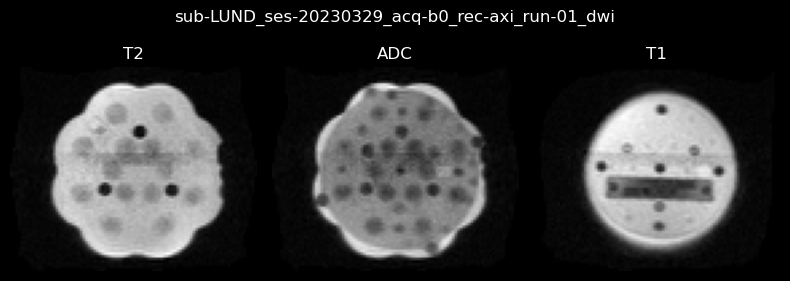

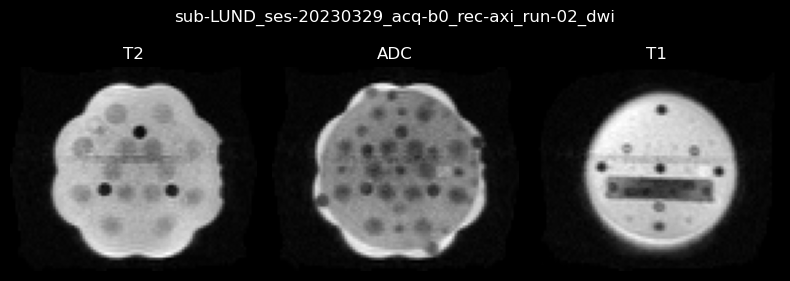

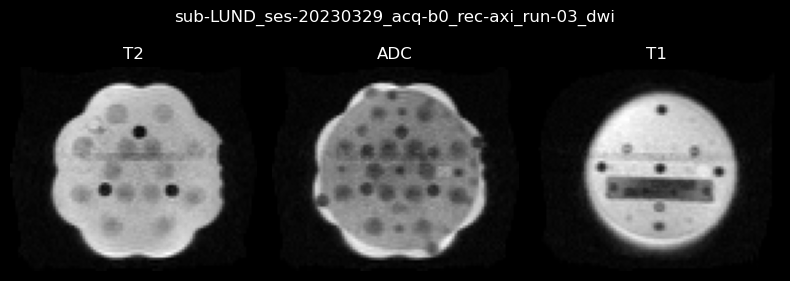

In [10]:
# Update layout
layout = bids.BIDSLayout(root=demo_dir+'/rawdata', derivatives=demo_dir+'/derivatives')

# Retreive all the b0 DWI images
bids_files = layout.get(scope='raw', extension='.nii.gz', suffix='dwi', acquisition='b0', session='20230329')

# Plot the QA images of the bids files
plot_mimics(bids_files, layout, toFile=True, verbose=True)

A T1-mask does not exist for sub-LUND_ses-20230329_acq-std_rec-cor_T1w.nii.gz. Molding one now.
Saving T1 mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230329/anat/sub-LUND_ses-20230329_acq-std_rec-cor_desc-T1_T1w.nii.gz...
A T1-mask does not exist for sub-LUND_ses-20230330_acq-std_rec-cor_T1w.nii.gz. Molding one now.
Saving T1 mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230330/anat/sub-LUND_ses-20230330_acq-std_rec-cor_desc-T1_T1w.nii.gz...
A T1-mask does not exist for sub-LUND_ses-20230331_acq-std_rec-cor_T1w.nii.gz. Molding one now.
Saving T1 mask to /Users/petter/Code/GHOST/demo/derivatives/masks/sub-LUND/ses-20230331/anat/sub-LUND_ses-20230331_acq-std_rec-cor_desc-T1_T1w.nii.gz...


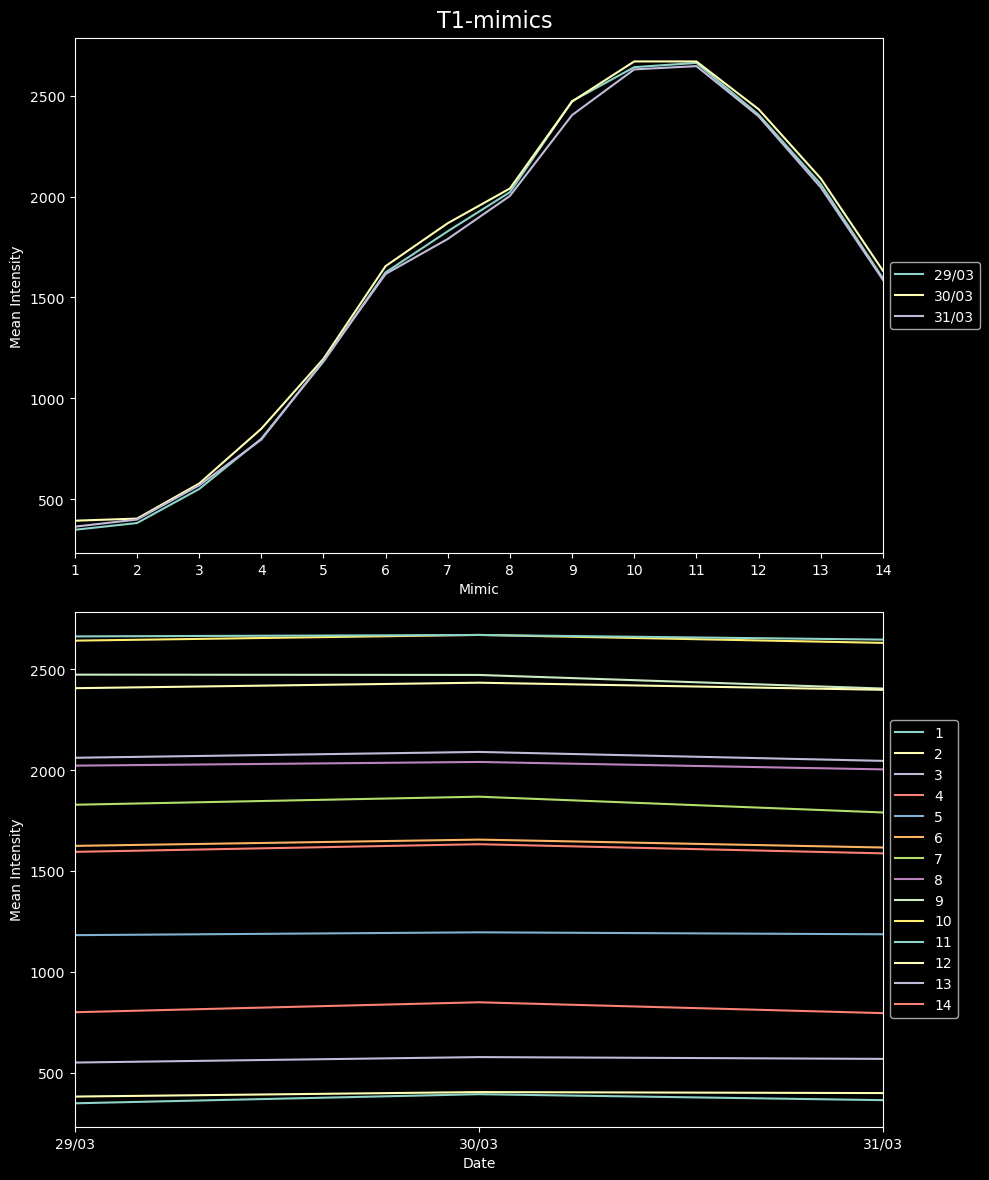

In [11]:
# Plot Mean of each LabelValue as a function of Session (time). Each LabelValue corresponds to it's own line.
# Update layout
layout = bids.BIDSLayout(root=demo_dir+'/rawdata', derivatives=demo_dir+'/derivatives')

# Select all standard coronal T1w images
bids_files = layout.get(scope='raw', extension='.nii.gz', suffix='T1w', acquisition='std', reconstruction='cor')

plot_signal_ROI(bids_files, 'T1', layout, verbose=True)